<a href="https://colab.research.google.com/github/cheon4050/Ai-DeepLearning/blob/main/%5B%EC%8B%A4%EC%8A%B505%5D%ED%95%A9%EC%84%B1%EA%B3%B1%EC%8B%A0%EA%B2%BD%EB%A7%9D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## https://github.com/cheon4050/Ai-DeepLearning

## Load Packages

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Settings 

## 1) important required libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils


In [ ]:
batch_size= 16 #64  #1
learning_rate = 0.0001
epoch = 20

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## Data Loader

In [ ]:
pwd

'/content'

## 트레이닝 데이터

In [48]:
img_dir = './animal/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                             shuffle=True, num_workers=2)


46


## 고정된 데이터 셋

In [49]:
img_dir = './animal/val'
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

dev_batch = data.DataLoader(dev_data, batch_size = batch_size,
                             shuffle=True, num_workers=2)


46


In [50]:
img_dir = './animal/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(size=imgsize),    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

test_batch = data.DataLoader(test_data, batch_size = batch_size,
                             shuffle=True, num_workers=2)


46


In [51]:
nclass = len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"%(train_data.__len__(), dev_data.__len__(),test_data.__len__()))

# of classes: 2
['cats', 'tigers']
{'cats': 0, 'tigers': 1}
46
Training: 46, Dev: 16, Test: 23


In [52]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cats', 'tigers']
['cats', 'tigers']
['cats', 'tigers']


# 3. Model

## 1) Pretrained VGG Model

In [54]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [ ]:
# 0~8까지의 Layer를 사용하겠다는 의미
# print(list(vgg.children())[0][0:8])

## 2) Customized Fully Model

In [55]:
# base_dim = 64
# fsize = int(imgsize/32)

# class MyVGG(nn.Module):
#     def __init__(self):
#         super(MyVGG, self).__init__()
#         self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
#         self.layer1 = nn.Sequential(
#             nn.Linear(8*base_dim * fsize * fsize, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, nclass),
#         )
#         # weight initialization
#         for m in self.layer1.modules():
#             #print(m)
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal(m.weight.data)  # REUL 일 때
#                 m.bias.data.fill_(0)
#             if isinstance(m, nn.Linear):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
#     def forward(self, x):
#         #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
#         out = self.layer0(x)
#         out = out.view(out.size(0), -1)
#         out = self.layer1(out)
#         return out
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

## Model on GPU

In [56]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [57]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Optimizer & Loss

In [58]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [59]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train == False):
    netname = './nets/catdog_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/catdog_vgg19'
    
    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습 재시작 시
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
    
#     for params in model.layer0.parameters():
#         params.required_grad = False
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
        
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i%disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %(total_time))
            
            # graph 
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 52.17, dev: 50.00, test: 30.43
0..

[0/20] loss: 0.527, 
Correct of train: 63.04, dev: 62.50, test: 73.91, 
time: 1.54 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.302, 
Correct of train: 97.83, dev: 87.50, test: 100.00, 
time: 19.88 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.337, 
Correct of train: 93.48, dev: 87.50, test: 100.00, 
time: 36.43 sec..
Total time: 36.43 sec


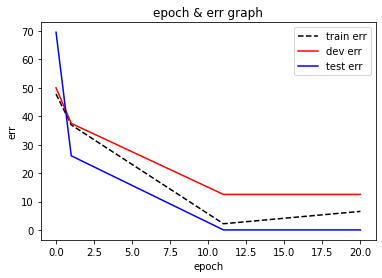

In [60]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label= 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc = "upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


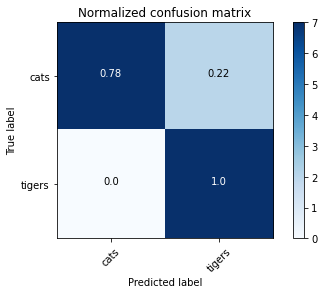

Confusion matrix, without normalization


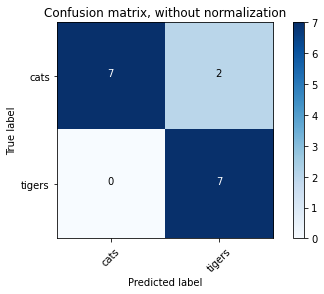

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.88 |	 1.00 |	 0.78 |	 0.88
 tigers: 0.88 |	 0.78 |	 1.00 |	 0.88
*accuracy: 0.88, precision: 0.89, recall: 0.89, *f1 score: 0.88
[AP]
cats: 0.97
tigers: 0.95

[mAP] 0.958
[miAP] 0.938


(array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1]),
 array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]),
 array([0.5674026 , 0.99964315, 0.93139333, 0.95746392, 0.85363334,
        0.88443106, 0.97750866, 0.9482277 , 0.9328807 , 0.86826527,
        0.96033251, 0.98707205, 0.83254224, 0.60991085, 0.99741101,
        0.99214309]))

In [61]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


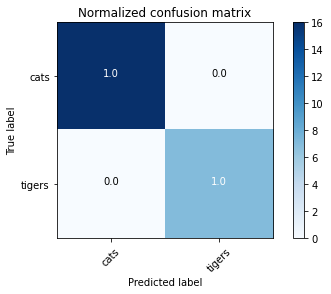

Confusion matrix, without normalization


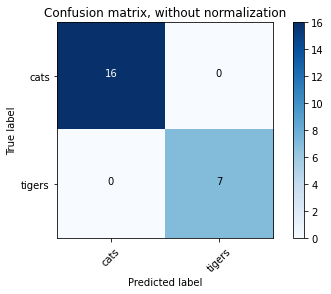

	 acc  |	 pre  |	 rec  |	 f1
 cats: 1.00 |	 1.00 |	 1.00 |	 1.00
 tigers: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP]
cats: 1.00
tigers: 1.00

[mAP] 1.000
[miAP] 1.000


In [62]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cats
 True predicted images/total cats category: 7 / 9
Predicted probability:
[0.88443106 0.11556896]


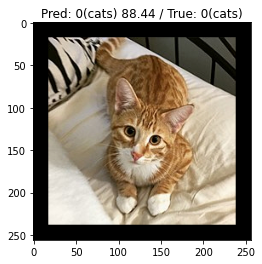

Predicted probability:
[0.997411   0.00258898]


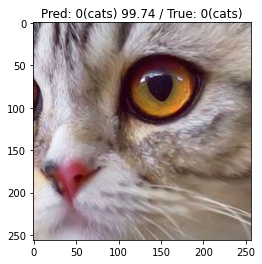

 False predicted images/total cats category: 2 / 9
Predicted probability:
[0.1317347 0.8682653]


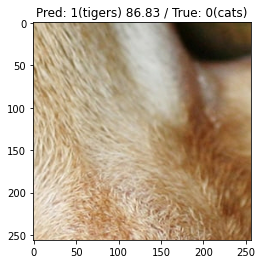

Predicted probability:
[0.06711933 0.9328807 ]


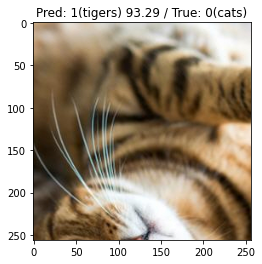

Category: tigers
 True predicted images/total tigers category: 7 / 7
Predicted probability:
[0.14636666 0.85363334]


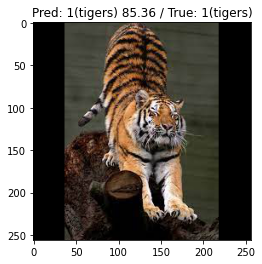

Predicted probability:
[0.01292793 0.98707205]


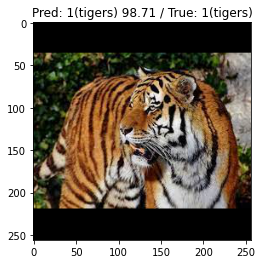

 False predicted images/total tigers category: 0 / 7


In [63]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)


In [ ]:
class MyResnet(nn.Module):
    def __init__(self):
        super(MyResnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:8])
        self.layer1 = nn.Sequential(
            nn.Linear(2048*8*8, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out
                

In [ ]:
ls

animal.zip  nets/  __pycache__/  sample_data/  test/  train/  utils.py  val/


In [46]:
!unzip -qq "./animal 2.zip"

In [47]:
ls

 animal/         animal.zip   __pycache__/   test/    utils.py
'animal 2.zip'   nets/        sample_data/   train/   val/
